In [1]:
## Import Packages
from __future__ import print_function

import numpy as np
import pandas as pd
from itertools import product

#Astro Software
import astropy.units as units
from astropy.coordinates import SkyCoord
from astropy.io import fits

#Plotting Packages
import matplotlib as mpl
import matplotlib.cm as cmplt
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import LogNorm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable

import seaborn as sns

from PIL import Image, ImageDraw

from yt.config import ytcfg
import yt
from yt.analysis_modules.ppv_cube.api import PPVCube
import yt.units as u

#Scattering NN
import torch
import torch.nn.functional as F
from torch import optim
from kymatio.torch import Scattering2D
device = "cpu"

#Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.decomposition import PCA, FastICA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

import skimage
from skimage import filters
from skimage.filters import window

from scipy.optimize import curve_fit
from scipy import linalg
from scipy import stats
from scipy.signal import general_gaussian
from scipy.ndimage import map_coordinates

# from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from scipy.sparse.csgraph import reverse_cuthill_mckee

#I/O
import h5py
import pickle
import glob
import copy
import time
import os
#from bs4 import BeautifulSoup
import scipy.io as sio

#Plotting Style
%matplotlib inline
plt.style.use('dark_background')
rcParams['text.usetex'] = False
rcParams['axes.titlesize'] = 20
rcParams['xtick.labelsize'] = 16
rcParams['ytick.labelsize'] = 16
rcParams['legend.fontsize'] = 12
rcParams['axes.labelsize'] = 20
rcParams['font.family'] = 'sans-serif'

#Threading
torch.set_num_threads=2
from multiprocessing import Pool

import ntpath
def path_leaf(path):
    head, tail = ntpath.split(path)
    out = os.path.splitext(tail)[0]
    return out

def hd5_open(file_name,name):
    f=h5py.File(file_name,'r', swmr=True)
    data = f[name][:]
    f.close()
    return data

from matplotlib.colors import LinearSegmentedColormap
cdict1 = {'red':   ((0.0, 0.0, 0.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 1.0, 1.0)),

         'green': ((0.0, 0.0, 0.0),
                   (1.0, 0.0, 0.0)),

         'blue':  ((0.0, 0.0, 1.0),
                   (0.5, 0.0, 0.0),
                   (1.0, 0.0, 0.0))
        }
blue_red1 = LinearSegmentedColormap('BlueRed1', cdict1,N=5000)

/opt/miniconda3/envs/IWST/lib/python3.8/_collections_abc.py:666: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  self[key]
<ipython-input-1-5af7b4fd052f>:28: VisibleDeprecationWarning: Development of the PPVCube module has been moved to the yt_astro_analysis package. This version is deprecated and will be removed from yt in a future release. See https://github.com/yt-project/yt_astro_analysis for further information.
  from yt.analysis_modules.ppv_cube.api import PPVCube


In [2]:
def DHC_iso(wst,J,L):
    (nk, Nd) = np.shape(wst)
    S0 = wst[:,0:2]
    S1 = wst[:,2:J*L+2]
    S2 = np.reshape(wst[:,J*L+3:],(nk,(J*L+1),(J*L+1)))
    
    S1iso = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            S1iso[:,j1] += S1[:,l1*J+j1]
    
    S2iso = np.zeros((nk,J,J,L))
    for j1 in range(J):
        for j2 in range(J):
            for l1 in range(L):
                for l2 in range(L):
                    deltaL = np.mod(l1-l2,L)
                    S2iso[:,j1,j2,deltaL] += S2[:,l1*J+j1,l2*J+j2]
                    
    Sphi1 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi1[:,j1] += S2[:,l1*J+j1,L*J]
            
    Sphi2 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi2[:,j1] += S2[:,L*J,l1*J+j1]
            
    return [S0,S1iso,wst[:,J*L+2].reshape(nk,1),S2iso.reshape(nk,J*J*L),Sphi1,Sphi2,S2[:,L*J,L*J].reshape(nk,1)]

In [22]:
def DHC_iso_vec(wst,J,L):
    (nk, Nd) = np.shape(wst)
    S0 = wst[:,0:2]
    S1 = wst[:,2:J*L+2]
    S2 = np.reshape(wst[:,J*L+3:],(nk,(J*L+1),(J*L+1)))
    
    S1iso = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            S1iso[:,j1] += S1[:,l1*J+j1]
    
    S2iso = np.zeros((nk,J,J,L))
    for j1 in range(J):
        for j2 in range(J):
            for l1 in range(L):
                for l2 in range(L):
                    deltaL = np.mod(l1-l2,L)
                    S2iso[:,j1,j2,deltaL] += S2[:,l1*J+j1,l2*J+j2]
                    
    Sphi1 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi1[:,j1] += S2[:,l1*J+j1,L*J]
            
    Sphi2 = np.zeros((nk,J))
    for j1 in range(J):
        for l1 in range(L):
            Sphi2[:,j1] += S2[:,L*J,l1*J+j1]
            
    return np.hstack((S0,S1iso,wst[:,J*L+2].reshape(nk,1),S2iso.reshape(nk,J*J*L),Sphi1,Sphi2,S2[:,L*J,L*J].reshape(nk,1)))

In [5]:
M = 2*360
angles = [i for i in np.linspace(0,2,M+1)]

In [33]:
mnist_DHC_angles = hd5_open('../scratch_AKS/mnist_DHC_angles_1_1_wd1_shift.h5','main/data')
iso_angles = DHC_iso(mnist_DHC_angles,5,8)

Text(0, 0.5, 'Coeff Magnitude')

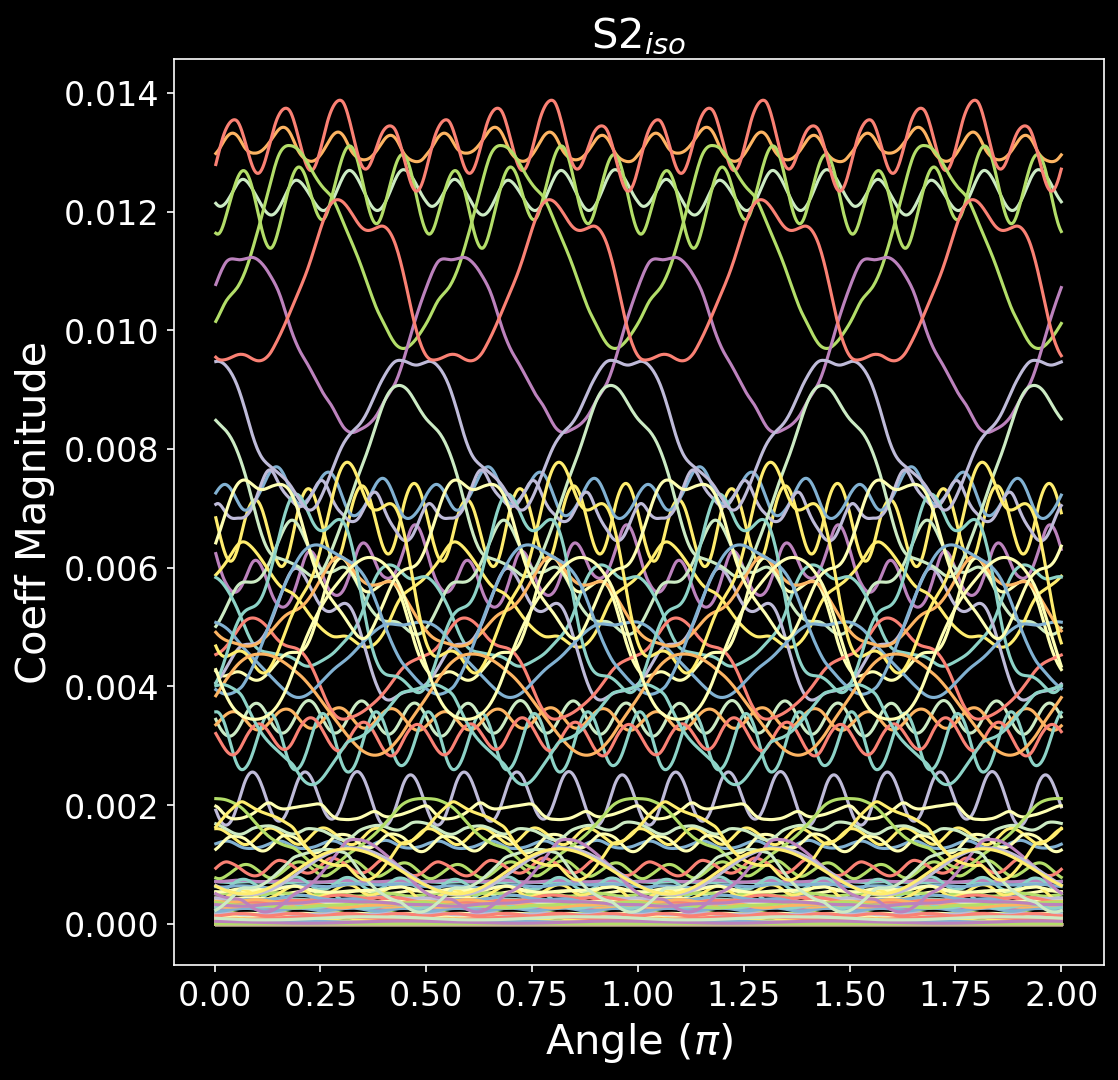

In [34]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot(angles[1:],iso_angles[3][1:,:])
plt.title('S2$_{iso}$')
plt.xlabel('Angle ($\pi$)')
plt.ylabel('Coeff Magnitude')

In [35]:
mnist_DHC_out_size_iso = DHC_iso_vec(mnist_DHC_angles,5,8)
angles_std = np.std(mnist_DHC_out_size_iso,axis=0)
np.mean(angles_std)

0.00013644505350159152

In [36]:
mnist_DHC_angles = hd5_open('../scratch_AKS/mnist_DHC_angles_1_1_wd1.h5','main/data')
iso_angles = DHC_iso(mnist_DHC_angles,5,8)

Text(0, 0.5, 'Coeff Magnitude')

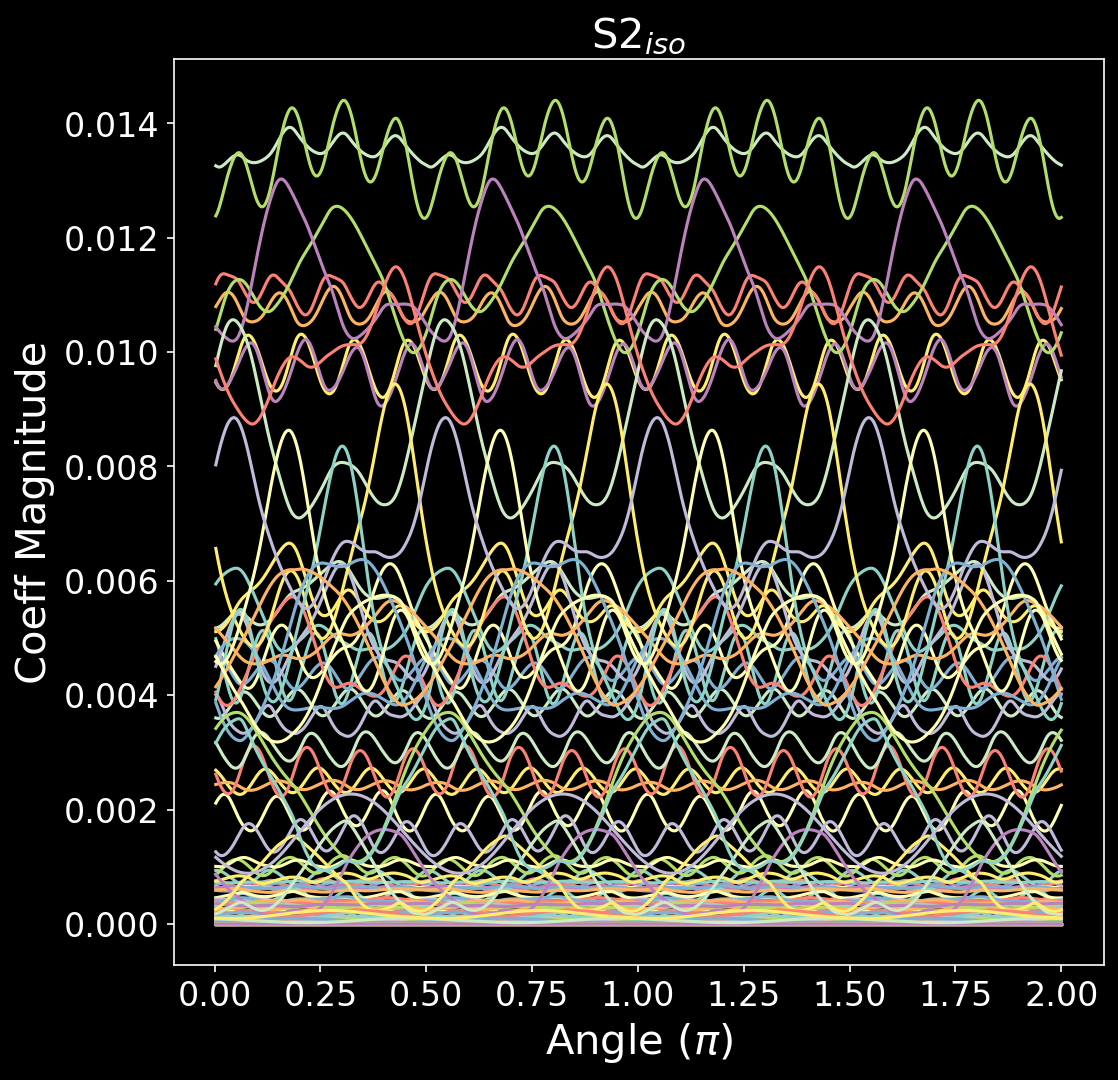

In [37]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot(angles[1:],iso_angles[3][1:,:])
plt.title('S2$_{iso}$')
plt.xlabel('Angle ($\pi$)')
plt.ylabel('Coeff Magnitude')

In [38]:
mnist_DHC_out_size_iso = DHC_iso_vec(mnist_DHC_angles,5,8)
angles_std = np.std(mnist_DHC_out_size_iso,axis=0)
np.mean(angles_std)

0.00014107559923624578

In [39]:
mnist_DHC_angles = hd5_open('../scratch_AKS/mnist_DHC_angles_1_1_wd3.h5','main/data')
iso_angles = DHC_iso(mnist_DHC_angles,5,8)

Text(0, 0.5, 'Coeff Magnitude')

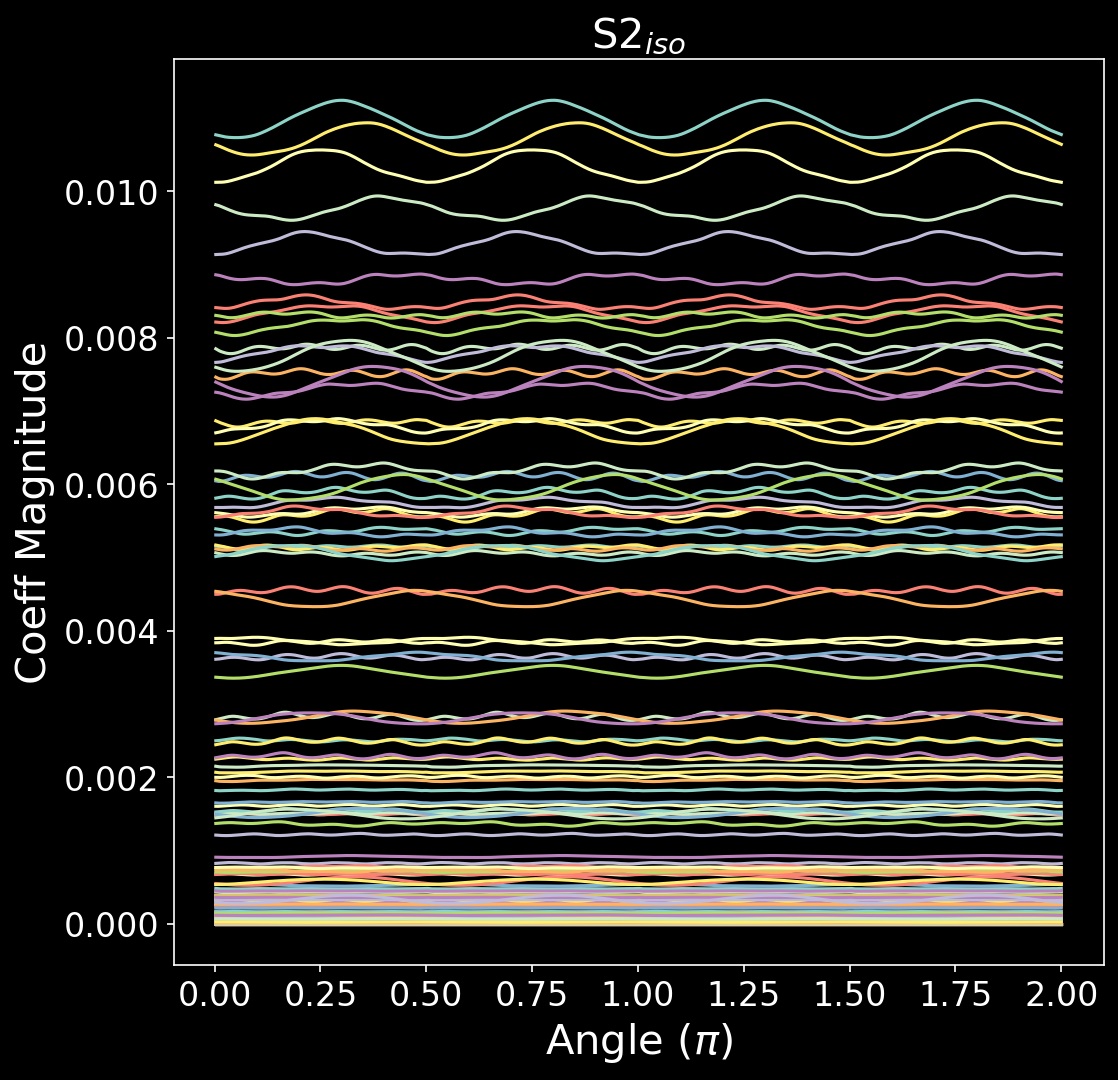

In [40]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot(angles[1:],iso_angles[3][1:,:])
plt.title('S2$_{iso}$')
plt.xlabel('Angle ($\pi$)')
plt.ylabel('Coeff Magnitude')

In [41]:
mnist_DHC_out_size_iso = DHC_iso_vec(mnist_DHC_angles,5,8)
angles_std = np.std(mnist_DHC_out_size_iso,axis=0)
np.mean(angles_std)

3.930285073634843e-05

In [42]:
mnist_DHC_angles = hd5_open('../scratch_AKS/mnist_DHC_angles_1_1_wd3_shift.h5','main/data')
iso_angles = DHC_iso(mnist_DHC_angles,5,8)

Text(0, 0.5, 'Coeff Magnitude')

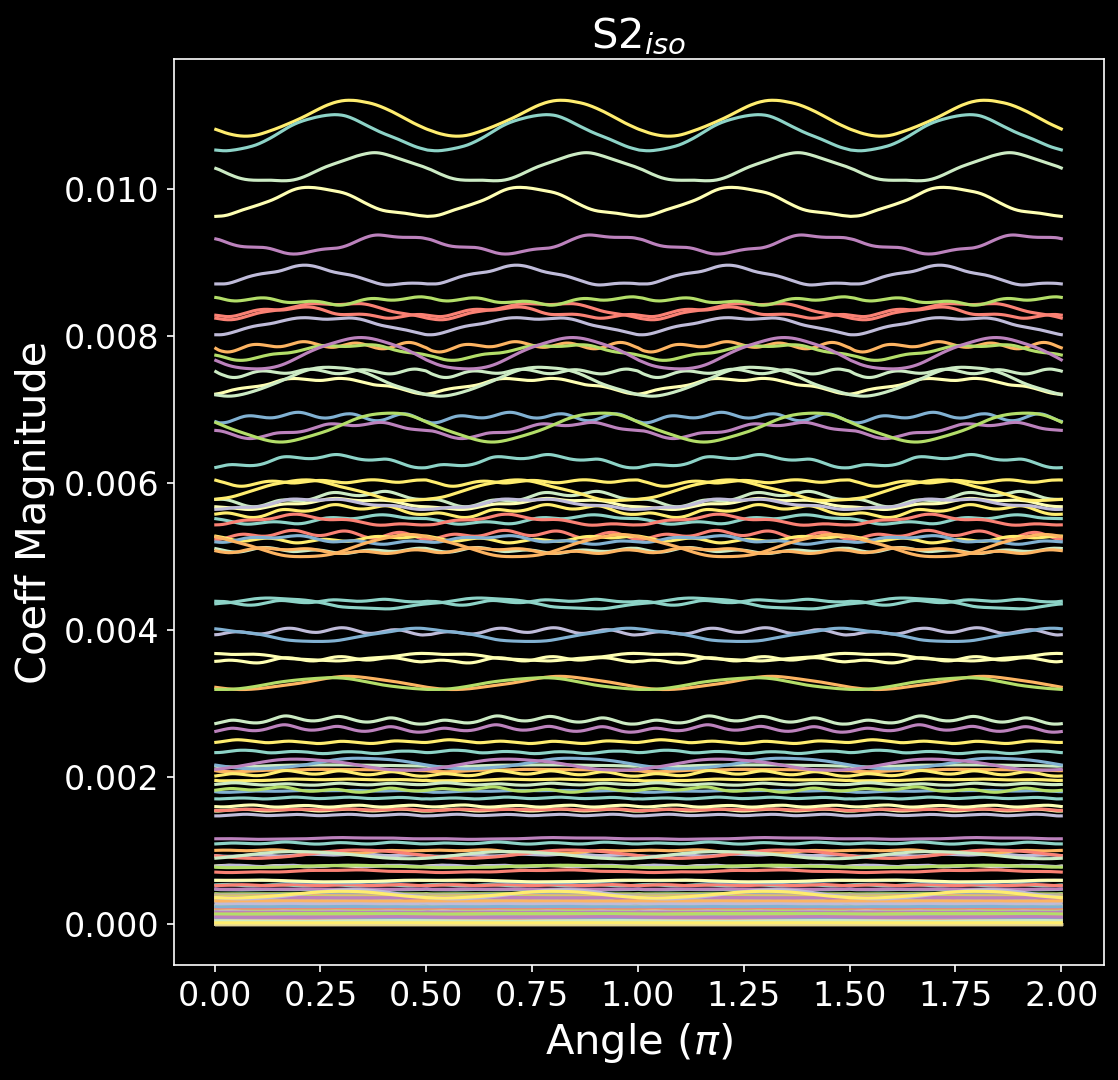

In [43]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot(angles[1:],iso_angles[3][1:,:])
plt.title('S2$_{iso}$')
plt.xlabel('Angle ($\pi$)')
plt.ylabel('Coeff Magnitude')

In [44]:
mnist_DHC_out_size_iso = DHC_iso_vec(mnist_DHC_angles,5,8)
angles_std = np.std(mnist_DHC_out_size_iso,axis=0)
np.mean(angles_std)

3.9550326644432415e-05

In [45]:
mnist_DHC_angles = hd5_open('../scratch_AKS/mnist_DHC_angles_1_1_wd2_shift.h5','main/data')
iso_angles = DHC_iso(mnist_DHC_angles,5,8)

Text(0, 0.5, 'Coeff Magnitude')

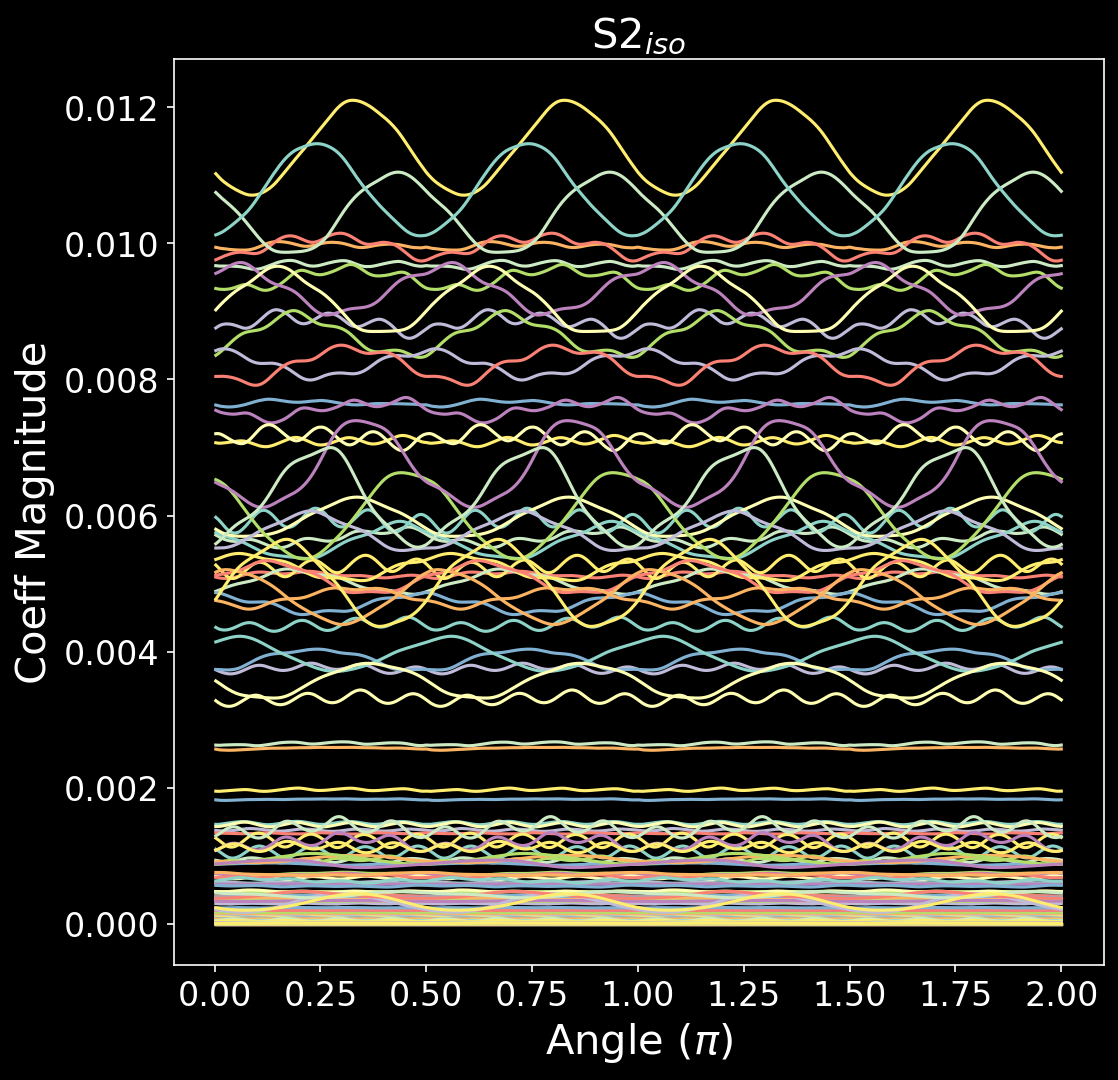

In [46]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot(angles[1:],iso_angles[3][1:,:])
plt.title('S2$_{iso}$')
plt.xlabel('Angle ($\pi$)')
plt.ylabel('Coeff Magnitude')

In [47]:
mnist_DHC_out_size_iso = DHC_iso_vec(mnist_DHC_angles,5,8)
angles_std = np.std(mnist_DHC_out_size_iso,axis=0)
np.mean(angles_std)

6.355539765979983e-05

In [48]:
mnist_DHC_angles = hd5_open('../scratch_AKS/stability_explore/mnist_DHC_angles_bicub_up_pad.h5','main/data')
iso_angles = DHC_iso(mnist_DHC_angles,5,8)

Text(0, 0.5, 'Coeff Magnitude')

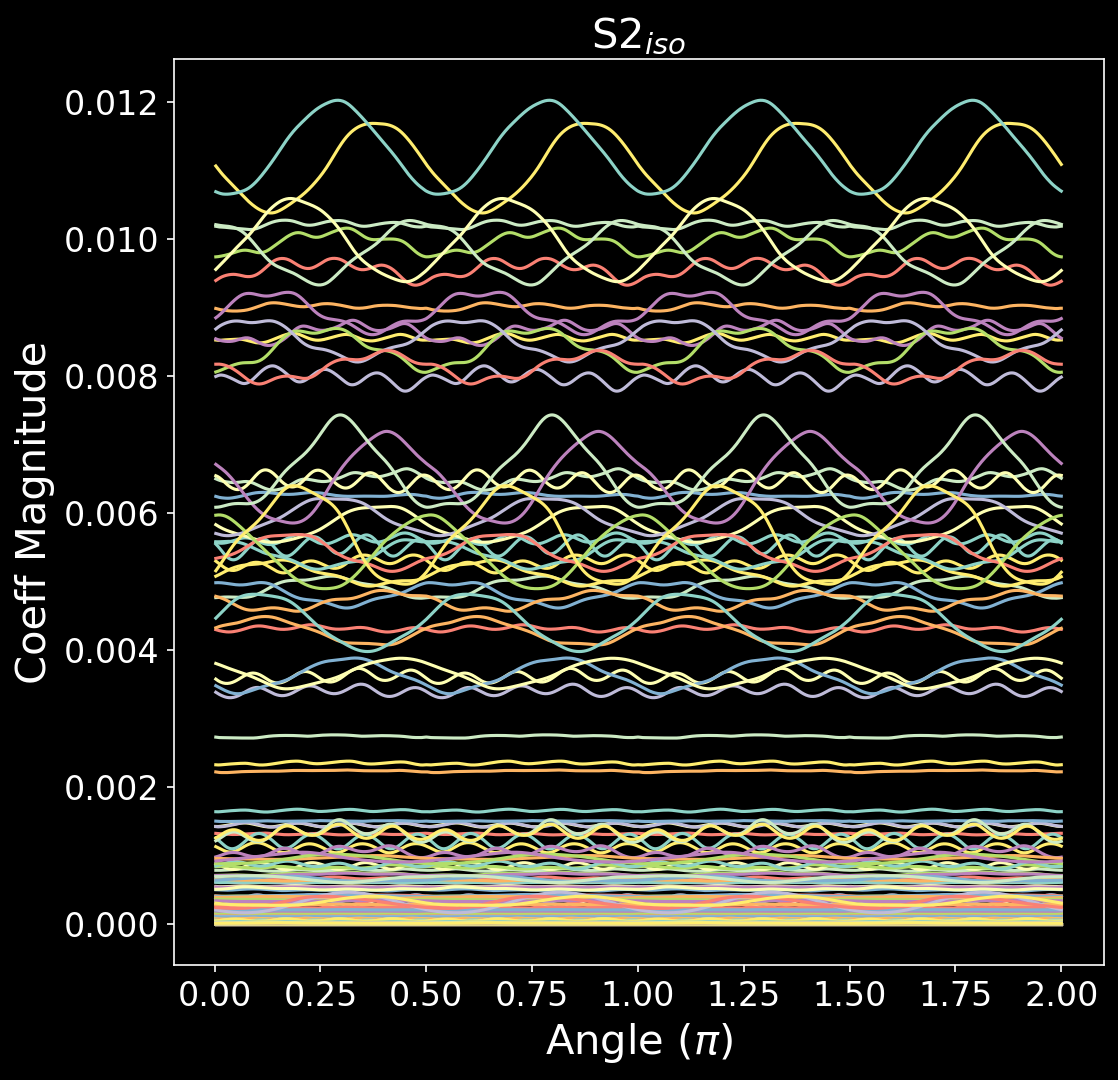

In [49]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot(angles[1:],iso_angles[3][1:,:])
plt.title('S2$_{iso}$')
plt.xlabel('Angle ($\pi$)')
plt.ylabel('Coeff Magnitude')

In [50]:
mnist_DHC_out_size_iso = DHC_iso_vec(mnist_DHC_angles,5,8)
angles_std = np.std(mnist_DHC_out_size_iso,axis=0)
np.mean(angles_std)

6.296985000225745e-05

In [54]:
mnist_train_y = hd5_open('../scratch_AKS/mnist_train_y.h5','main/data')
mnist_test_y = hd5_open('../scratch_AKS/mnist_test_y.h5','main/data')

In [56]:
def prec_LDA(lda,X_test,y_test):
    y_pred = lda.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    prec = precision_score(y_test, y_pred,average='micro')
    return prec

In [59]:
M = 100
angles = [i for i in np.linspace(0,2,100)]

In [90]:
mnist_DHC_out_sizetrain = hd5_open('../from_cannon/2021_01_21/mnist_DHC_train_ang_1_1.h5','main/data')
mnist_DHC_out_sizetest = hd5_open('../from_cannon/2021_01_21/mnist_DHC_test_ang_1_1.h5','main/data')
mnist_DHC_out_size_iso = DHC_iso_vec(mnist_DHC_out_sizetest,5,8)
mnist_DHC_out_size_iso.shape, mnist_DHC_out_sizetest.shape

((1000000, 219), (1000000, 1724))

In [91]:
mnist_DHC_out_size_iso_reshape = mnist_DHC_out_size_iso.reshape(10000,100,219)
angles_std = np.std(mnist_DHC_out_size_iso_reshape,axis=1)
np.mean(angles_std)

2.8541844710164978e-05

In [92]:
N = 10
lda = LDA(n_components=N-1)
lda.fit(DHC_iso_vec(mnist_DHC_out_sizetrain[0::6,:],5,8), mnist_train_y)
prec_LDA(lda,DHC_iso_vec(mnist_DHC_out_sizetest[0::100,:],5,8),mnist_test_y)

0.9239

In [57]:
prec_mnist_angles = []

N = 10
lda = LDA(n_components=N-1)
lda.fit(DHC_iso_vec(mnist_DHC_out_sizetrain,5,8), np.repeat(mnist_train_y,6))
    
prec_mnist_angles = []
for i in range(100):
    prec_mnist_angles.append(prec_LDA(lda,DHC_iso_vec(mnist_DHC_out_sizetest[i::100,:],5,8),mnist_test_y))
    
np.mean(100*np.array(prec_mnist_angles)), np.std(100*np.array(prec_mnist_angles))

(91.0355, 0.15646325447209622)

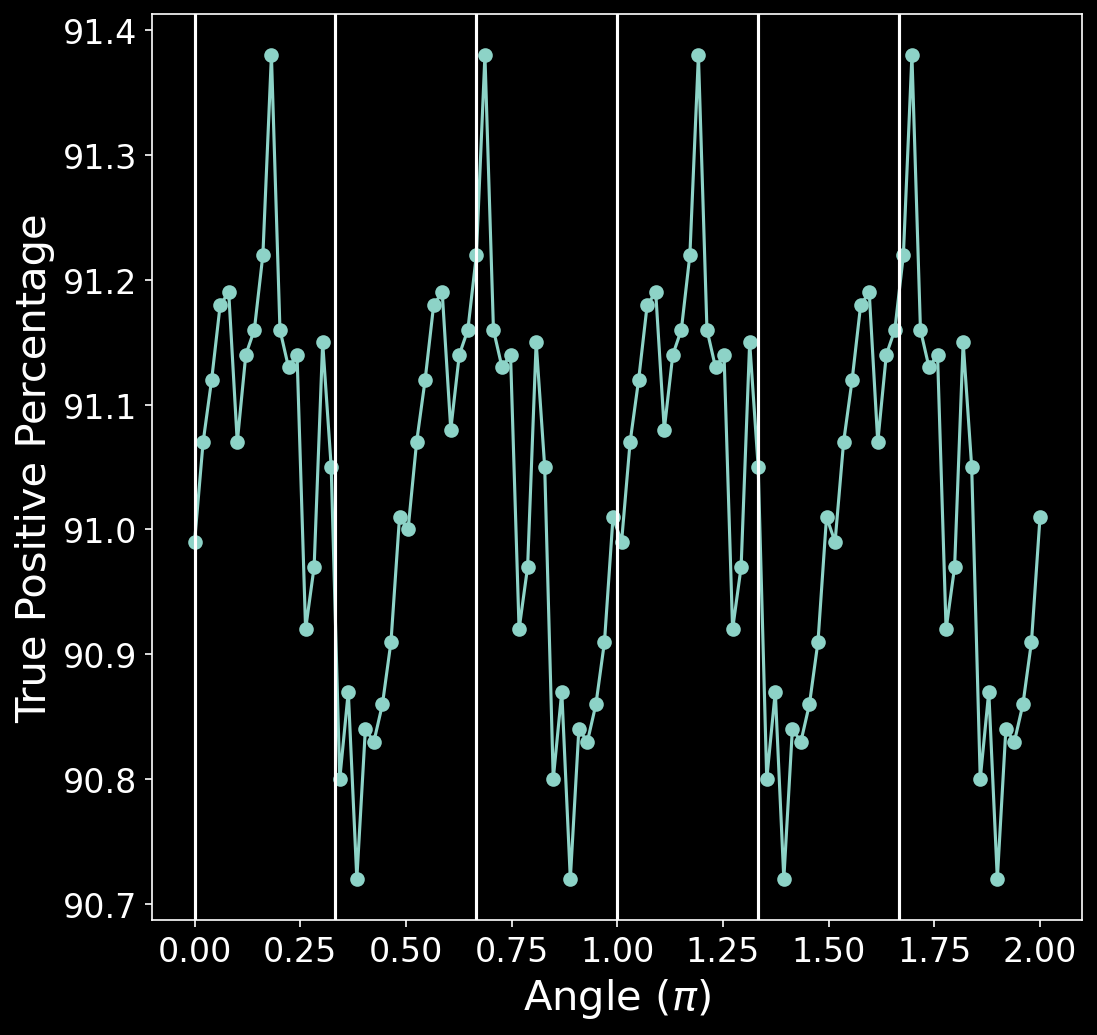

In [60]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot(angles,100*np.array(prec_mnist_angles), linestyle='-', marker='o')
plt.xlabel('Angle ($\pi$)')
plt.ylabel('True Positive Percentage')
plt.axvline(x=0.333)
plt.axvline(x=0.666)
plt.axvline(x=1)
plt.axvline(x=1.333)
plt.axvline(x=1.666)
plt.axvline(x=0)

In [88]:
mnist_DHC_out_sizetrain = hd5_open('../from_cannon/2021_01_23/mnist_DHC_train_ang_1_1_wd2_shift.h5','main/data')
mnist_DHC_out_sizetest = hd5_open('../scratch_AKS/mnist_DHC_test_ang_1_1_wd2_shift.h5','main/data')
mnist_DHC_out_size_iso = DHC_iso_vec(mnist_DHC_out_sizetest,5,8)
mnist_DHC_out_size_iso.shape, mnist_DHC_out_sizetest.shape

((1000000, 219), (1000000, 1724))

In [89]:
N = 10
lda = LDA(n_components=N-1)
lda.fit(DHC_iso_vec(mnist_DHC_out_sizetrain[0::6,:],5,8), mnist_train_y)
prec_LDA(lda,DHC_iso_vec(mnist_DHC_out_sizetest[0::100,:],5,8),mnist_test_y)

0.925

In [62]:
mnist_DHC_out_size_iso_reshape = mnist_DHC_out_size_iso.reshape(10000,100,219)
angles_std = np.std(mnist_DHC_out_size_iso_reshape,axis=1)
np.mean(angles_std)

2.8672978443967523e-05

In [63]:
prec_mnist_angles = []

N = 10
lda = LDA(n_components=N-1)
lda.fit(DHC_iso_vec(mnist_DHC_out_sizetrain,5,8), np.repeat(mnist_train_y,6))
    
prec_mnist_angles = []
for i in range(100):
    prec_mnist_angles.append(prec_LDA(lda,DHC_iso_vec(mnist_DHC_out_sizetest[i::100,:],5,8),mnist_test_y))
    
np.mean(100*np.array(prec_mnist_angles)), np.std(100*np.array(prec_mnist_angles))

(91.0883, 0.14974681966572645)

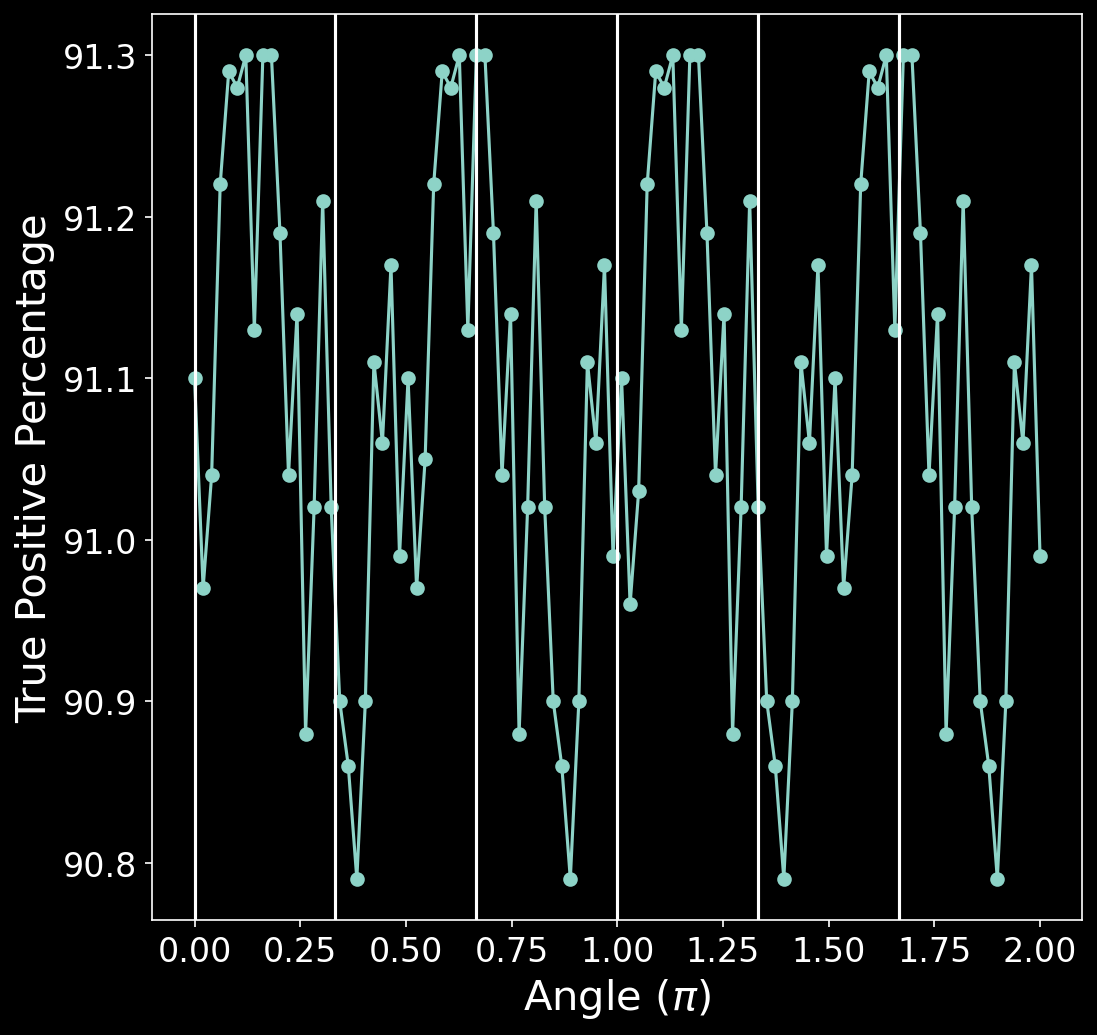

In [64]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot(angles,100*np.array(prec_mnist_angles), linestyle='-', marker='o')
plt.xlabel('Angle ($\pi$)')
plt.ylabel('True Positive Percentage')
plt.axvline(x=0.333)
plt.axvline(x=0.666)
plt.axvline(x=1)
plt.axvline(x=1.333)
plt.axvline(x=1.666)
plt.axvline(x=0)

In [86]:
mnist_DHC_out_sizetrain = hd5_open('../from_cannon/2021_01_23/mnist_DHC_train_ang_1_1_wd1_shift.h5','main/data')
mnist_DHC_out_sizetest = hd5_open('../from_cannon/2021_01_23/mnist_DHC_test_ang_1_1_wd1_shift.h5','main/data')
mnist_DHC_out_size_iso = DHC_iso_vec(mnist_DHC_out_sizetest,5,8)
mnist_DHC_out_size_iso.shape, mnist_DHC_out_sizetest.shape

((1000000, 219), (1000000, 1724))

In [87]:
N = 10
lda = LDA(n_components=N-1)
lda.fit(DHC_iso_vec(mnist_DHC_out_sizetrain[0::6,:],5,8), mnist_train_y)
prec_LDA(lda,DHC_iso_vec(mnist_DHC_out_sizetest[0::100,:],5,8),mnist_test_y)

0.9106

In [66]:
mnist_DHC_out_size_iso_reshape = mnist_DHC_out_size_iso.reshape(10000,100,219)
angles_std = np.std(mnist_DHC_out_size_iso_reshape,axis=1)
np.mean(angles_std)

8.192437822311004e-05

In [67]:
prec_mnist_angles = []

N = 10
lda = LDA(n_components=N-1)
lda.fit(DHC_iso_vec(mnist_DHC_out_sizetrain,5,8), np.repeat(mnist_train_y,6))
    
prec_mnist_angles = []
for i in range(100):
    prec_mnist_angles.append(prec_LDA(lda,DHC_iso_vec(mnist_DHC_out_sizetest[i::100,:],5,8),mnist_test_y))
    
np.mean(100*np.array(prec_mnist_angles)), np.std(100*np.array(prec_mnist_angles))

(88.75560000000002, 0.1523306929019897)

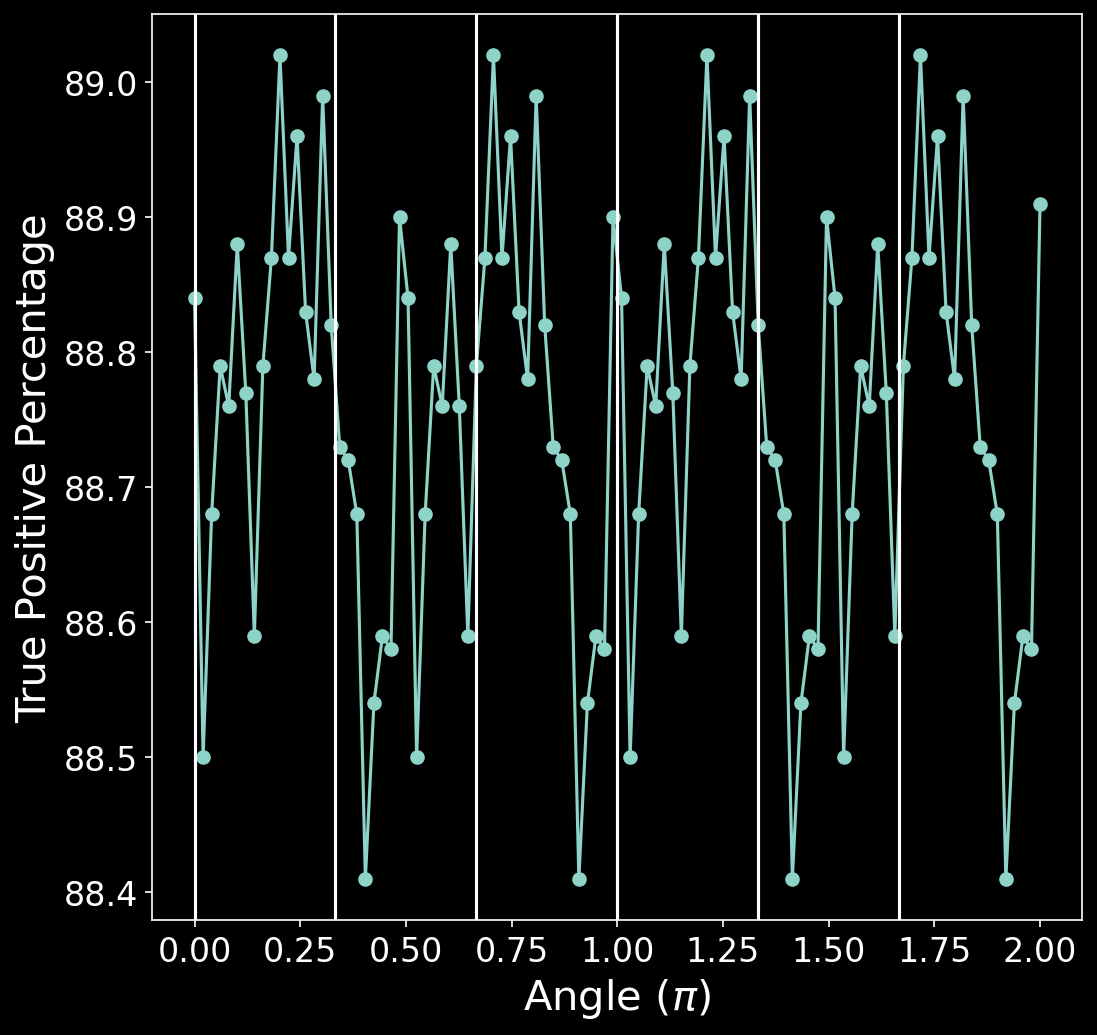

In [68]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot(angles,100*np.array(prec_mnist_angles), linestyle='-', marker='o')
plt.xlabel('Angle ($\pi$)')
plt.ylabel('True Positive Percentage')
plt.axvline(x=0.333)
plt.axvline(x=0.666)
plt.axvline(x=1)
plt.axvline(x=1.333)
plt.axvline(x=1.666)
plt.axvline(x=0)

In [84]:
mnist_DHC_out_sizetrain = hd5_open('../from_cannon/2021_01_23/mnist_DHC_train_ang_1_1_wd3_shift.h5','main/data')
mnist_DHC_out_sizetest = hd5_open('../from_cannon/2021_01_23/mnist_DHC_test_ang_1_1_wd3_shift.h5','main/data')
mnist_DHC_out_size_iso = DHC_iso_vec(mnist_DHC_out_sizetest,5,8)
mnist_DHC_out_size_iso_reshape = mnist_DHC_out_size_iso.reshape(10000,100,219)
angles_std = np.std(mnist_DHC_out_size_iso_reshape,axis=1)
np.mean(angles_std)

1.5576644007224008e-05

In [85]:
N = 10
lda = LDA(n_components=N-1)
lda.fit(DHC_iso_vec(mnist_DHC_out_sizetrain[0::6,:],5,8), mnist_train_y)
prec_LDA(lda,DHC_iso_vec(mnist_DHC_out_sizetest[0::100,:],5,8),mnist_test_y)

0.9287

In [70]:
prec_mnist_angles = []

N = 10
lda = LDA(n_components=N-1)
lda.fit(DHC_iso_vec(mnist_DHC_out_sizetrain,5,8), np.repeat(mnist_train_y,6))
    
prec_mnist_angles = []
for i in range(100):
    prec_mnist_angles.append(prec_LDA(lda,DHC_iso_vec(mnist_DHC_out_sizetest[i::100,:],5,8),mnist_test_y))
    
np.mean(100*np.array(prec_mnist_angles)), np.std(100*np.array(prec_mnist_angles))

(91.36359999999999, 0.11530411961417392)

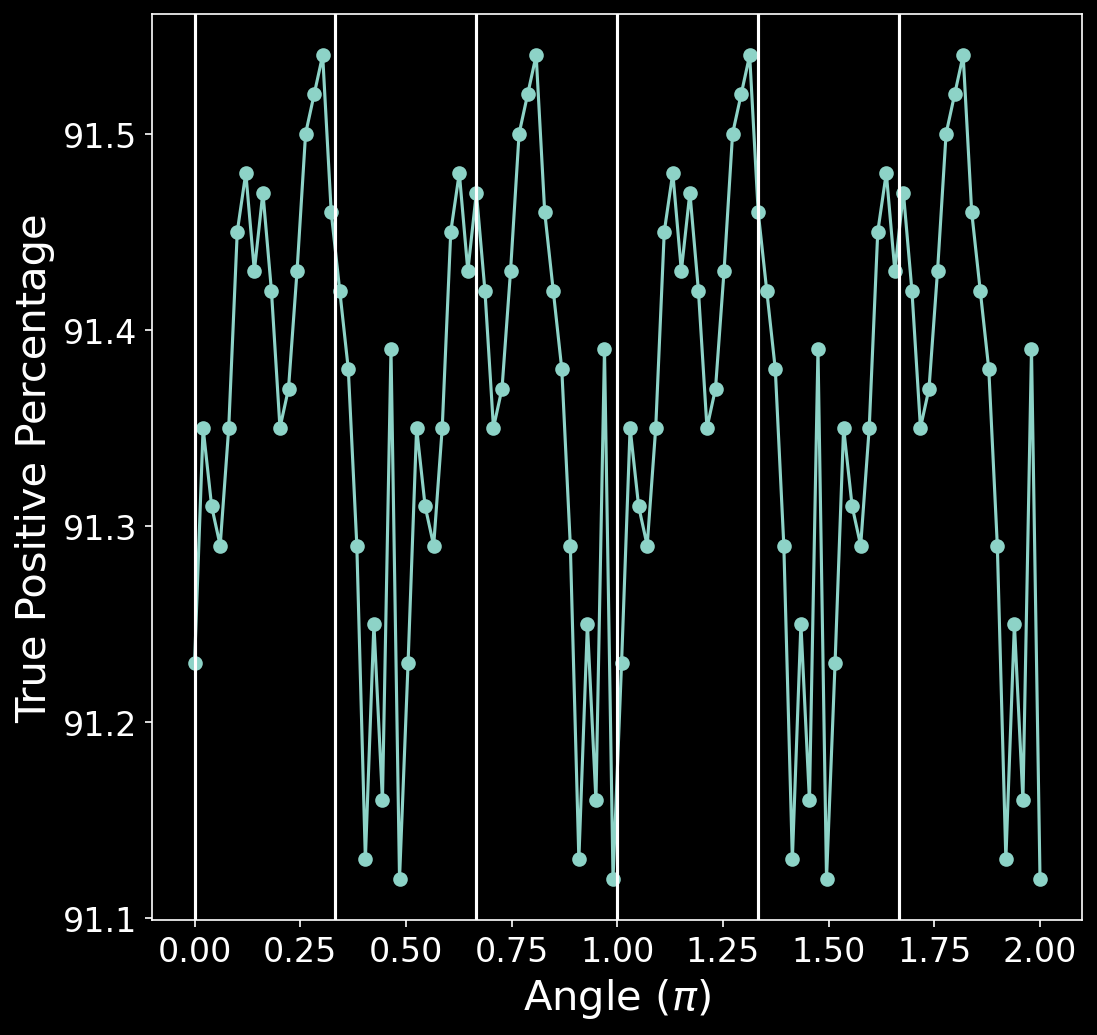

In [71]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot(angles,100*np.array(prec_mnist_angles), linestyle='-', marker='o')
plt.xlabel('Angle ($\pi$)')
plt.ylabel('True Positive Percentage')
plt.axvline(x=0.333)
plt.axvline(x=0.666)
plt.axvline(x=1)
plt.axvline(x=1.333)
plt.axvline(x=1.666)
plt.axvline(x=0)

In [82]:
mnist_DHC_out_sizetrain = hd5_open('../from_cannon/2021_01_22/mnist_DHC_train_ang_1_1_wd3.h5','main/data')
mnist_DHC_out_sizetest = hd5_open('../from_cannon/2021_01_23/mnist_DHC_test_ang_1_1_wd3.h5','main/data')
mnist_DHC_out_size_iso = DHC_iso_vec(mnist_DHC_out_sizetest,5,8)
mnist_DHC_out_size_iso_reshape = mnist_DHC_out_size_iso.reshape(10000,100,219)
angles_std = np.std(mnist_DHC_out_size_iso_reshape,axis=1)
np.mean(angles_std)

1.558957712037619e-05

In [83]:
N = 10
lda = LDA(n_components=N-1)
lda.fit(DHC_iso_vec(mnist_DHC_out_sizetrain[0::6,:],5,8), mnist_train_y)
prec_LDA(lda,DHC_iso_vec(mnist_DHC_out_sizetest[0::100,:],5,8),mnist_test_y)

0.9282

In [73]:
prec_mnist_angles = []

N = 10
lda = LDA(n_components=N-1)
lda.fit(DHC_iso_vec(mnist_DHC_out_sizetrain,5,8), np.repeat(mnist_train_y,6))
    
prec_mnist_angles = []
for i in range(100):
    prec_mnist_angles.append(prec_LDA(lda,DHC_iso_vec(mnist_DHC_out_sizetest[i::100,:],5,8),mnist_test_y))
    
np.mean(100*np.array(prec_mnist_angles)), np.std(100*np.array(prec_mnist_angles))

(91.38680000000001, 0.08652028663845186)

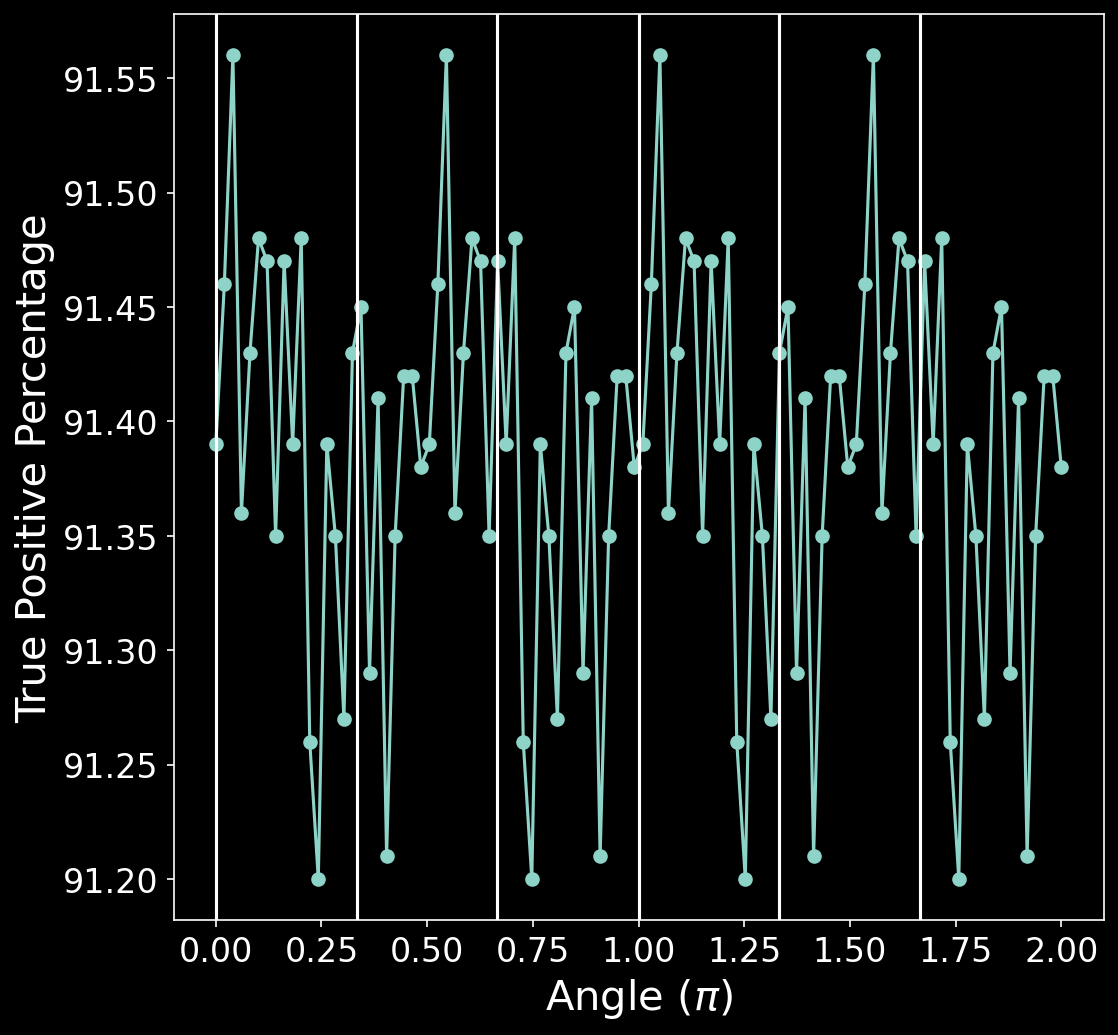

In [74]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot(angles,100*np.array(prec_mnist_angles), linestyle='-', marker='o')
plt.xlabel('Angle ($\pi$)')
plt.ylabel('True Positive Percentage')
plt.axvline(x=0.333)
plt.axvline(x=0.666)
plt.axvline(x=1)
plt.axvline(x=1.333)
plt.axvline(x=1.666)
plt.axvline(x=0)

In [75]:
mnist_DHC_out_sizetrain = hd5_open('../from_cannon/2021_01_22/mnist_DHC_train_ang_1_1_wd1.h5','main/data')
mnist_DHC_out_sizetest = hd5_open('../scratch_AKS/mnist_DHC_test_ang_1_1_wd1.h5','main/data')
mnist_DHC_out_size_iso = DHC_iso_vec(mnist_DHC_out_sizetest,5,8)
mnist_DHC_out_size_iso_reshape = mnist_DHC_out_size_iso.reshape(10000,100,219)
angles_std = np.std(mnist_DHC_out_size_iso_reshape,axis=1)
np.mean(angles_std)

8.469441966995523e-05

In [76]:
prec_mnist_angles = []

N = 10
lda = LDA(n_components=N-1)
lda.fit(DHC_iso_vec(mnist_DHC_out_sizetrain,5,8), np.repeat(mnist_train_y,6))
    
prec_mnist_angles = []
for i in range(100):
    prec_mnist_angles.append(prec_LDA(lda,DHC_iso_vec(mnist_DHC_out_sizetest[i::100,:],5,8),mnist_test_y))
    
np.mean(100*np.array(prec_mnist_angles)), np.std(100*np.array(prec_mnist_angles))

(88.68540000000002, 0.20617187005020807)

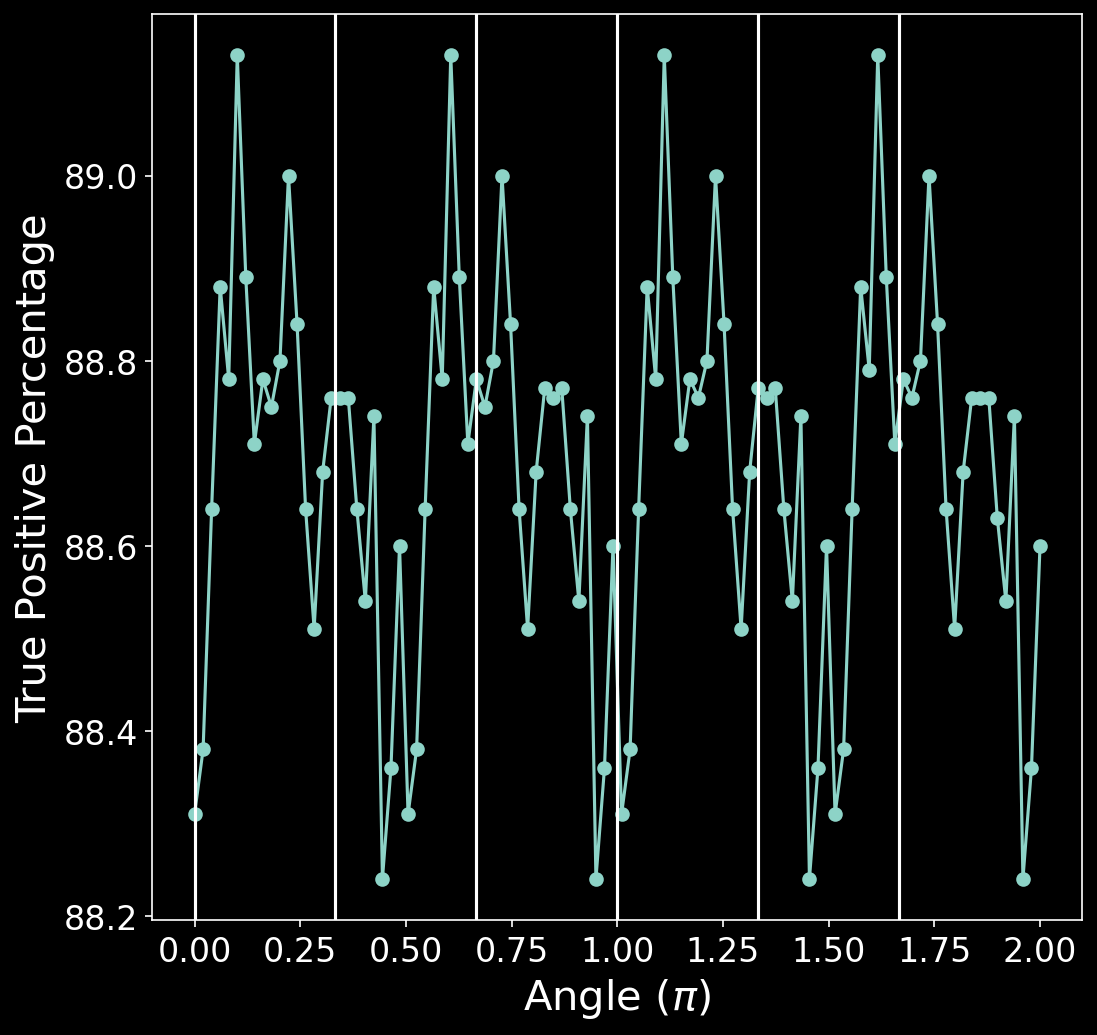

In [77]:
fig = plt.figure(figsize=(8,8),dpi=150)

ax = fig.add_subplot(111) 
ax.plot(angles,100*np.array(prec_mnist_angles), linestyle='-', marker='o')
plt.xlabel('Angle ($\pi$)')
plt.ylabel('True Positive Percentage')
plt.axvline(x=0.333)
plt.axvline(x=0.666)
plt.axvline(x=1)
plt.axvline(x=1.333)
plt.axvline(x=1.666)
plt.axvline(x=0)

In [80]:
N = 10
lda = LDA(n_components=N-1)
lda.fit(DHC_iso_vec(mnist_DHC_out_sizetrain[0::6,:],5,8), mnist_train_y)
prec_LDA(lda,DHC_iso_vec(mnist_DHC_out_sizetest[0::100,:],5,8),mnist_test_y)

0.9088